# Single-label classification

> <i>This tutorial highlights how to quickly build a Learner and train a model on a binary classification task.</i>

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/nbs/10a_tutorial_classification.ipynb)

In [ ]:
#| hide
#Install `fastMONAI` if notebook is running on Google Colab
try:
    import google.colab
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()
except:
    print('Running locally')

## Beginner

The following line imports all of the functions and classes from the fastMONAI library: 

In [ ]:
from fastMONAI.vision_all import *

### Download external data
For this task, we will download the T1-weighted brain images of healthy subjects (n=556) from the IXI dataset (https://brain-development.org/ixi-dataset/) with the corresponding metadata. We will download the data with the following line of code. Note that the data set is ~ 4.5G, and the download may take some time.

In [ ]:
path = Path('../data')
path.mkdir(exist_ok=True)

In [ ]:
STUDY_DIR = download_ixi_data(path=path)

Images already downloaded and extracted to ../data/IXI/T1_images
2022-09-05 14:54:56,757 - INFO - Expected md5 is None, skip md5 check for file ../data/IXI/IXI.xls.
2022-09-05 14:54:56,758 - INFO - File exists: ../data/IXI/IXI.xls, skipped downloading.
Preprocessing ../data/IXI/IXI.xls


### Looking at data

Let's look at how the processed DataFrame is formatted: 

In [ ]:
df = pd.read_csv(STUDY_DIR/'dataset.csv')

In [ ]:
df.head()

,t1_path,subject_id,gender,age_at_scan
0,../data/IXI/T1_images/IXI002-Guys-0828-T1.nii.gz,IXI002,F,35.80
1,../data/IXI/T1_images/IXI012-HH-1211-T1.nii.gz,IXI012,M,38.78
2,../data/IXI/T1_images/IXI013-HH-1212-T1.nii.gz,IXI013,M,46.71
3,../data/IXI/T1_images/IXI014-HH-1236-T1.nii.gz,IXI014,F,34.24
4,../data/IXI/T1_images/IXI015-HH-1258-T1.nii.gz,IXI015,M,24.28


efore feeding the data into a model, we must create a `DataLoaders` object for our dataset. There are several ways to get the data in `DataLoaders`. 
In the following line, we call the ` ImageDataLoaders.from_df` factory method, which is the most basic way of building a `DataLoaders`. 

Here, we pass the processed DataFrame, define the columns for the images `fn_col` and the labels `label_col`, voxel spacing `resample`, some transforms `item_tfms`, and the batch size `bs`. 

In [ ]:
dls = MedImageDataLoaders.from_df(df, fn_col='t1_path', label_col='gender', 
        resample=1, item_tfms=[ZNormalization(), PadOrCrop(size=256)], bs=4)

We can now take a look at a batch of images in the training set using `show_batch`:

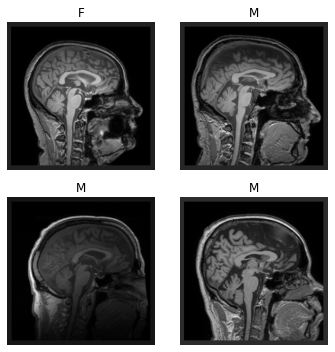

In [ ]:
dls.show_batch(figsize=(5,5),anatomical_plane=2)

### Create and train a 3D model 

Next, we import a classification network from MONAI, and define the input image size, number of classes to predict, channels, etc.  

In [ ]:
from monai.networks.nets import Classifier

model = Classifier(in_shape=[1, 256, 256, 256], classes=2, 
    channels=(8, 16, 32, 64, 128), strides=(2, 2, 2, 2))

Then we can create a `Learner`, which is a fastai object that combines the data and our defined model for training:

In [ ]:
learn = Learner(dls, model, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,8.190948,3.175142,0.857143,01:26
1,2.547504,1.543512,0.901786,01:25


With the model trained, let's look at some predictions on the validation data.

> **Note:** Small random variations are involved in training CNN models; hence, you will probably not see exactly the same results shown here.

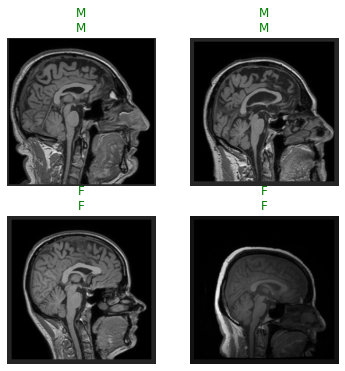

In [ ]:
learn.show_results(anatomical_plane=2)

Showing samples with target value their corresponding predictions (target|predicition). todo

In [ ]:
learn.save('model-1')

Path('models/model-1.pth')

### Inference

We can have a look at where our trained model becomes confused while making predictions on the validation data:

In [ ]:
learn.load('model-1');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

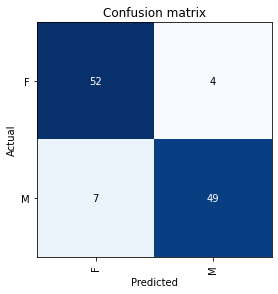

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

           F       0.88      0.93      0.90        56
           M       0.92      0.88      0.90        56

    accuracy                           0.90       112
   macro avg       0.90      0.90      0.90       112
weighted avg       0.90      0.90      0.90       112



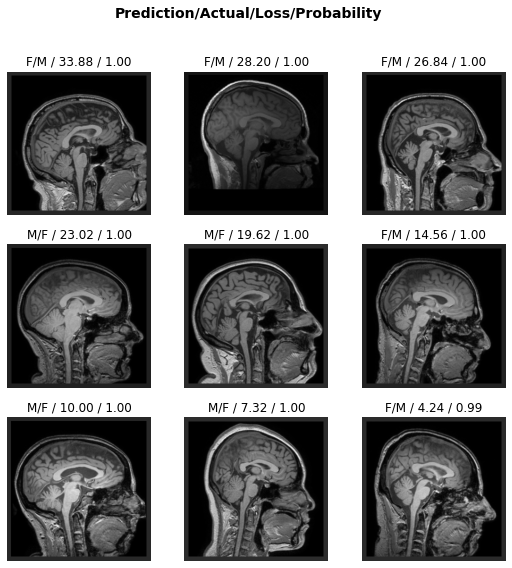

In [ ]:
interp.plot_top_losses(k=9, anatomical_plane=2) 

## Advanced

`fastMONAI.vision_all import *` imports the following: 

In [ ]:
from fastMONAI.vision_core import *
from fastMONAI.vision_data import *
from fastMONAI.vision_augmentation import *
from fastMONAI.vision_loss import *
from fastMONAI.vision_metrics import * 
from fastMONAI.vision_utils import * 
from fastMONAI.external_data import *
from fastMONAI.dataset_info import *

from fastai.vision.all import *

Grab the data (if not already fetched).

In [ ]:
path = Path('../data')
path.mkdir(exist_ok=True)
STUDY_DIR = download_ixi_data(path=path)
df = pd.read_csv(STUDY_DIR/'dataset.csv')

IXI-T1.tar: 100%|██████████████████████████████████████████████████████████████████████████| 4.51G/4.51G [06:53<00:00, 11.7MB/s]

2022-09-04 14:10:43,976 - INFO - Downloaded: ../data/IXI/IXI-T1.tar
2022-09-04 14:10:43,977 - INFO - Expected md5 is None, skip md5 check for file ../data/IXI/IXI-T1.tar.
2022-09-04 14:10:43,978 - INFO - Writing into directory: ../data/IXI/T1_images.


2022-09-04 14:11:08,904 - INFO - Expected md5 is None, skip md5 check for file ../data/IXI/IXI.xls.
2022-09-04 14:11:08,905 - INFO - File exists: ../data/IXI/IXI.xls, skipped downloading.
Preprocessing ../data/IXI/IXI.xls


### Get information about the dataset

`MedDataset` is a class to extract and present useful information about your dataset.

In [ ]:
med_dataset = MedDataset(path=STUDY_DIR/'T1_images', max_workers=12)

In [ ]:
data_info_df = med_dataset.summary()

In [ ]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
3,256,256,150,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI002-Guys-0828-T1.nii.gz,498
2,256,256,146,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI035-IOP-0873-T1.nii.gz,74
4,256,256,150,0.9766,0.9766,1.2,PSR+,../data/IXI/T1_images/IXI297-Guys-0886-T1.nii.gz,5
0,256,256,130,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI023-Guys-0699-T1.nii.gz,2
1,256,256,140,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI020-Guys-0700-T1.nii.gz,2


In [ ]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([0.9375, 0.9375, 1.2], False)

In [ ]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[267.0, 267.0, 150.0]

In [ ]:
bs=4
in_shape = [1, 256, 256, 160]

In [ ]:
item_tfms = [ZNormalization(), PadOrCrop(in_shape[1:]), RandomAffine(scales=0, degrees=5, isotropic=True)] 

As we mentioned earlier, there are several ways to get the data in `DataLoaders`. In this section, let's rebuild using `DataBlock`. 
Here we need to define what our input and target should be (`MedImage` and `CategoryBlock` for classification), how to get the images and the labels, how to split the data, item transforms that should be applied during training, reorder voxel orientations, and voxel spacing. Take a look at fastai's documentation for DataBlock for further information: https://docs.fast.ai/data.block.html#DataBlock. 

In [ ]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), CategoryBlock), 
                      splitter=RandomSplitter(seed=42),
                      get_x=ColReader('t1_path'),
                      get_y=ColReader('gender'),
                      item_tfms=item_tfms, 
                      reorder=reorder,
                      resample=resample)

Now we pass our processed DataFrame and the bath size to create a `DataLoaders` object. 

In [ ]:
dls = dblock.dataloaders(df, bs=bs)

In [ ]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(449, 112)

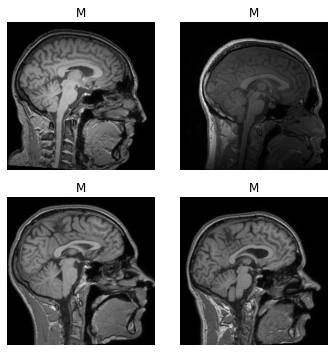

In [ ]:
dls.show_batch(max_n=6, figsize=(5, 5), anatomical_plane=2)

In [ ]:
from monai.networks.nets import Classifier

model = Classifier(in_shape=[1, 256, 256, 160], classes=2, channels=(8, 16, 32, 64, 128),
                   strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)

In [ ]:
learn = Learner(dls, model, metrics=[accuracy])

In [ ]:
learn.summary()

Classifier (Input shape: 4 x 1 x 256 x 256 x 160)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 8 x 128 x 128 x 
Conv3d                                    224        True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    1736       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    224        True      
____________________________________________________________________________
                     4 x 16 x 64 x 64 x  
Conv3d                                    3472       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d       

We used the default learning rate before, but we might want to use the model and the dataset to find a reasonable value automatically. For this, we can use the learning rate finder from fastai. 
Rule of thumb to pick a learning rate: 
- Minimum/10 
- The steepest point (where the loss is clearly decreasing)

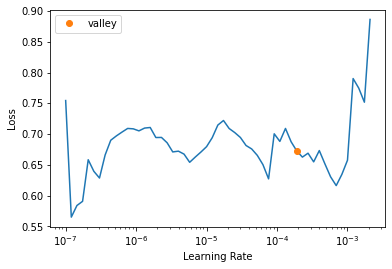

In [ ]:
lr = learn.lr_find()

In [ ]:
print(lr.valley)

0.00019054606673307717


In [ ]:
learn.fit_one_cycle(4, lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,1.836071,0.691266,0.848214,00:39
1,2.227007,2.053748,0.785714,00:39
2,1.021351,1.002934,0.848214,00:40
3,0.268604,0.641782,0.866071,00:39


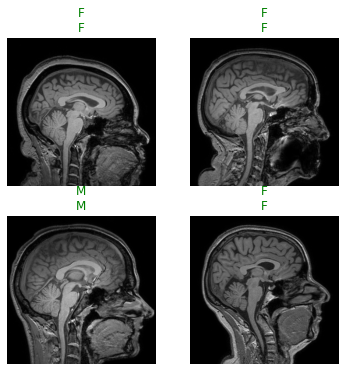

In [ ]:
learn.show_results(anatomical_plane=2)

In [ ]:
learn.save('model-2')

Path('models/model-2.pth')

## Test-time augmentation

Test-time augmentation (TTA) is a technique where you apply transforms used during traing when making predictions to produce average output.  

In [ ]:
learn.load('model-2');

In [ ]:
preds, targs = learn.tta(); 

In [ ]:
accuracy(preds, targs)

TensorBase(0.9286)